In [1]:
QUICK_MODE = True  # Only model for a subset of the players (for quicker computations)

# 1/ Cleaning data (converting types and removing NAs)

In [38]:
import pandas as pd, numpy as np
import importlib
from tennis_predictor import clean_data
%matplotlib inline

In [3]:
df = pd.read_csv("data.csv", low_memory=False)
COLUMNS = [
    "Location", "Tournament", "Date",
    "Series",
    "Court", "Surface",
    "Round", "Best of",
    "Winner", "Loser", "WRank", "LRank",
]
GAME_STATS_COLS = [
    "W1", "L1", "W2", "L2", "W3", "L3", "W4", "L4", "W5", "L5",
    "Wsets", "Lsets"
]
df = df[COLUMNS + GAME_STATS_COLS]

In [4]:
df.iloc[377]

Location                 Memphis
Tournament       Kroger St. Jude
Date                  14/02/2000
Series        International Gold
Court                     Indoor
Surface                     Hard
Round                  1st Round
Best of                        3
Winner                 Mamiit C.
Loser                  Jensen L.
WRank                        135
LRank                         NR
W1                             7
L1                             5
W2                             6
L2                             2
W3                           NaN
L3                           NaN
W4                           NaN
L4                           NaN
W5                           NaN
L5                           NaN
Wsets                          2
Lsets                          0
Name: 377, dtype: object

In [5]:
data = clean_data.convert_to_numeric(df, ["WRank", "LRank"])
data = data.assign(
    Date=pd.to_datetime(data.Date, format="%d/%m/%Y")
)
data = clean_data.drop_nas(data, COLUMNS)

Location       0
Tournament     0
Date           0
Series         0
Court          0
Surface        0
Round          0
Best of        0
Winner         0
Loser          0
WRank         16
LRank         98
dtype: int64


In [6]:
data.iloc[:,:20].head()

,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,W1,L1,W2,L2,W3,L3,W4,L4
0,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,Ljubicic I.,63.0,77.0,6.0,4.0,6.0,2.0,NaN,NaN,NaN,NaN
1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Enqvist T.,Clement A.,5.0,56.0,6.0,3.0,6.0,3.0,NaN,NaN,NaN,NaN
2,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,Baccanello P.,40.0,655.0,6.0,7.0,7.0,5.0,6.0,3.0,NaN,NaN
3,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Federer R.,Knippschild J.,65.0,87.0,6.0,1.0,6.0,4.0,NaN,NaN,NaN,NaN
4,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Fromberg R.,Woodbridge T.,81.0,198.0,7.0,6.0,5.0,7.0,6.0,4.0,NaN,NaN


In [7]:
data.iloc[:,20:].head()

,W5,L5,Wsets,Lsets
0,NaN,NaN,2.0,0.0
1,NaN,NaN,2.0,0.0
2,NaN,NaN,2.0,1.0
3,NaN,NaN,2.0,0.0
4,NaN,NaN,2.0,1.0


In [8]:
data.Round.value_counts()

1st Round        21584
2nd Round        12819
Quarterfinals     4382
3rd Round         3320
Semifinals        2225
The Final         1111
4th Round          784
Round Robin        312
0th Round            1
Name: Round, dtype: int64

In [9]:
data.dtypes, data.shape

(Location              object
 Tournament            object
 Date          datetime64[ns]
 Series                object
 Court                 object
 Surface               object
 Round                 object
 Best of                int64
 Winner                object
 Loser                 object
 WRank                float64
 LRank                float64
 W1                   float64
 L1                   float64
 W2                   float64
 L2                   float64
 W3                   float64
 L3                   float64
 W4                   float64
 L4                   float64
 W5                   float64
 L5                   float64
 Wsets                float64
 Lsets                float64
 dtype: object, (46538, 24))

In [10]:
data.Round.value_counts()

1st Round        21584
2nd Round        12819
Quarterfinals     4382
3rd Round         3320
Semifinals        2225
The Final         1111
4th Round          784
Round Robin        312
0th Round            1
Name: Round, dtype: int64

# 2/ Labelling players 1 and 2 (input: data Dataframe)

* The player specific columns are basically grouped into two groups: the various columns about the Winner and the various columns about the Loser
* We need to somehow pick, for each match a "Player1" and a "Player2", otherwise, otherwise all the observations would all belong to a single class! (ie the Winner always wins of course :P )

## Does the better ranked player always win?

In [11]:
matches_where_better_wins = data[data.WRank < data.LRank].shape[0]
matches_where_better_wins / data.shape[0]

0.6568395719626972

## They do about 65% of the time !!

#### So if we pick the better player as "Player1", we know that Player1 only wins 65% of the time. If we try to predict whether Player1 wins, we have 65% of "True" and "35%" of "False"

In [12]:
from tennis_predictor import transform_data
P1_P2 = transform_data.number_players(data, lambda x: x.WRank < x.LRank)
print(P1_P2.shape)
P1_P2.head()

(46538, 16)


,P1_Name,P1_Rank,P1_1,P1_2,P1_3,P1_4,P1_5,P1_Sets,P2_Name,P2_Rank,P2_1,P2_2,P2_3,P2_4,P2_5,P2_Sets
0,Dosedel S.,63.0,6.0,6.0,NaN,NaN,NaN,2.0,Ljubicic I.,77.0,4.0,2.0,NaN,NaN,NaN,0.0
1,Enqvist T.,5.0,6.0,6.0,NaN,NaN,NaN,2.0,Clement A.,56.0,3.0,3.0,NaN,NaN,NaN,0.0
2,Escude N.,40.0,6.0,7.0,6.0,NaN,NaN,2.0,Baccanello P.,655.0,7.0,5.0,3.0,NaN,NaN,1.0
3,Federer R.,65.0,6.0,6.0,NaN,NaN,NaN,2.0,Knippschild J.,87.0,1.0,4.0,NaN,NaN,NaN,0.0
4,Fromberg R.,81.0,7.0,5.0,6.0,NaN,NaN,2.0,Woodbridge T.,198.0,6.0,7.0,4.0,NaN,NaN,1.0


#### Let's now concatenate those new columns with the other columns that we care about (the first 8 columns in data, we don't the other Winner/Loser columns as we just copied/renamed them)

In [13]:
data_with_P1_P2 = data.iloc[:,:10].join(P1_P2, how="inner")
print(data_with_P1_P2.shape)
data_with_P1_P2.head()

(46538, 26)


,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,...,P1_5,P1_Sets,P2_Name,P2_Rank,P2_1,P2_2,P2_3,P2_4,P2_5,P2_Sets
0,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,Ljubicic I.,...,NaN,2.0,Ljubicic I.,77.0,4.0,2.0,NaN,NaN,NaN,0.0
1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Enqvist T.,Clement A.,...,NaN,2.0,Clement A.,56.0,3.0,3.0,NaN,NaN,NaN,0.0
2,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,Baccanello P.,...,NaN,2.0,Baccanello P.,655.0,7.0,5.0,3.0,NaN,NaN,1.0
3,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Federer R.,Knippschild J.,...,NaN,2.0,Knippschild J.,87.0,1.0,4.0,NaN,NaN,NaN,0.0
4,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Fromberg R.,Woodbridge T.,...,NaN,2.0,Woodbridge T.,198.0,6.0,7.0,4.0,NaN,NaN,1.0


####  Let's add the target

In [14]:
data_with_P1_P2 = data_with_P1_P2.assign(
    Player1Wins=lambda x: x.P1_Name ==  x.Winner
)

In [15]:
if {"Winner", "Loser"}.intersection(data_with_P1_P2.columns):  # So that we can rerun this cell :)
    data_with_P1_P2 = data_with_P1_P2.drop(["Winner", "Loser"], axis=1)
print(data_with_P1_P2.columns)
data_with_P1_P2.Player1Wins.mean()

Index(['Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round',
       'Best of', 'P1_Name', 'P1_Rank', 'P1_1', 'P1_2', 'P1_3', 'P1_4', 'P1_5',
       'P1_Sets', 'P2_Name', 'P2_Rank', 'P2_1', 'P2_2', 'P2_3', 'P2_4', 'P2_5',
       'P2_Sets', 'Player1Wins'],
      dtype='object')


0.65683957196269716

# 3/ Basic EDA (input: data_with_P1_P2)

At this point I haven't decided which features exactly I'm going to use:
* derived features (that would represent the players history up to the day of the match we'd try to predict), **excluding the ranks**
* the player's ranks augmented with the features above

In [16]:
eda_df = data_with_P1_P2.assign(RankDiff= lambda x: x.P2_Rank - x.P1_Rank)
corr_cols = [
    "Player1Wins", "P1_Rank", "P2_Rank", "RankDiff", "Best of"
]
eda_df[corr_cols].corr()

,Player1Wins,P1_Rank,P2_Rank,RankDiff,Best of
Player1Wins,1.000000,-0.120933,0.052750,0.088316,0.063309
P1_Rank,-0.120933,1.000000,0.356869,0.113219,-0.091759
P2_Rank,0.052750,0.356869,1.000000,0.968552,-0.027539
RankDiff,0.088316,0.113219,0.968552,1.000000,-0.004851
Best of,0.063309,-0.091759,-0.027539,-0.004851,1.000000


In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
lr = LogisticRegression()

X = eda_df[["P1_Rank", "P2_Rank", "RankDiff", "Best of"]]
Y = eda_df.Player1Wins
lr.fit(X, Y)
lr.score(X, Y)

0.65505608320082509

# 4/ Adding features derived from past history of the players (input: eda_df)

## For every point in time, we want to compute statistics about players **up until that point in time**

### Let's get a list of all the players

In [86]:
all_players = pd.concat([eda_df.P1_Name, eda_df.P2_Name]).unique()
if QUICK_MODE:
    all_players = np.random.choice(all_players, int(len(all_players) / 50))
    all_players = np.append(all_players, ["Federer R.", "Nadal R.", "Djokovic N.", "Murray A."])
all_players.shape

(31,)

In [87]:
from tennis_predictor import features_engineering
importlib.reload(features_engineering)
eda_df.Round.value_counts()

1st Round        21584
2nd Round        12819
Quarterfinals     4382
3rd Round         3320
Semifinals        2225
The Final         1111
4th Round          784
Round Robin        312
0th Round            1
Name: Round, dtype: int64

### 4.A - Let's compute basic boolean features (extra columns) using the same index, ie tennis match resolution

In [88]:
players_stats = features_engineering.compute_games_played_and_won(eda_df, all_players)
players_stats = features_engineering.compute_win_round_type(players_stats, all_players)

In [89]:
players_stats.head()

,Location,Tournament,Date,Series,Court,Surface,Round,Best of,P1_Name,P1_Rank,...,Djokovic N.__Won_4th Round,Djokovic N.__Won_Round Robin,Murray A.__Won_1st Round,Murray A.__Won_2nd Round,Murray A.__Won_Quarterfinals,Murray A.__Won_3rd Round,Murray A.__Won_Semifinals,Murray A.__Won_The Final,Murray A.__Won_4th Round,Murray A.__Won_Round Robin
0,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,63.0,...,0,0,0,0,0,0,0,0,0,0
1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Enqvist T.,5.0,...,0,0,0,0,0,0,0,0,0,0
2,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,40.0,...,0,0,0,0,0,0,0,0,0,0
3,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Federer R.,65.0,...,0,0,0,0,0,0,0,0,0,0
4,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Fromberg R.,81.0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
## Let's double check the data for Rafael Nadal

In [91]:
nadal_stats_columns = [c for c in players_stats.columns if "Nadal" in c]
nadal_stats = players_stats[players_stats["Nadal R.__Played"] & (players_stats.Tournament == "French Open")][["Date"] + nadal_stats_columns]
nadal_stats.head(7)

,Date,Nadal R.__Played,Nadal R.__Won,Nadal R.__Won_1st Round,Nadal R.__Won_2nd Round,Nadal R.__Won_Quarterfinals,Nadal R.__Won_3rd Round,Nadal R.__Won_Semifinals,Nadal R.__Won_The Final,Nadal R.__Won_4th Round,Nadal R.__Won_Round Robin
15800,2005-05-23,1,1,1,0,0,0,0,0,0,0
15868,2005-05-25,1,1,0,1,0,0,0,0,0,0
15894,2005-05-27,1,1,0,0,0,1,0,0,0,0
15910,2005-05-30,1,1,0,0,0,0,0,0,1,0
15913,2005-05-31,1,1,0,0,1,0,0,0,0,0
15917,2005-06-03,1,1,0,0,0,0,1,0,0,0
15918,2005-06-05,1,1,0,0,0,0,0,1,0,0


In [92]:
nadal_stats.resample("D", on="Date").sum().sum()
## Looks good!! As of this dataset last update, Nadal won the French Open nine times (ie he won 9 finals)

Nadal R.__Played               75.0
Nadal R.__Won                  72.0
Nadal R.__Won_1st Round        12.0
Nadal R.__Won_2nd Round        11.0
Nadal R.__Won_Quarterfinals     9.0
Nadal R.__Won_3rd Round        12.0
Nadal R.__Won_Semifinals        9.0
Nadal R.__Won_The Final         9.0
Nadal R.__Won_4th Round        10.0
Nadal R.__Won_Round Robin       0.0
dtype: float64

### 4.B - Let's resample with daily frequencies

This shouldn't conceptually change anything if we assume that players play only once per day maximum

In [93]:
stats_columns = [c for c in players_stats.columns if "__" in c]

Players can actually play more than once a day, but let's ignore this for now, the final features will be some kind of rolling window so this is fine actually

In [94]:
resampled_stats = players_stats[["Date"] + stats_columns].resample("D", on="Date").sum()
resampled_stats = resampled_stats.fillna(0)  # We don't have matches every single day of the year, so we're going to have NAs as a result of the resample
resampled_stats.head()

,Saville L.__Played,Whitehouse W.__Played,Krstin P.__Played,Kim K__Played,Prpic F.__Played,Greul S.__Played,Trifu G.__Played,Goellner M.K.__Played,Gonzalez F.__Played,Ehrat S.__Played,...,Djokovic N.__Won_4th Round,Djokovic N.__Won_Round Robin,Murray A.__Won_1st Round,Murray A.__Won_2nd Round,Murray A.__Won_Quarterfinals,Murray A.__Won_3rd Round,Murray A.__Won_Semifinals,Murray A.__Won_The Final,Murray A.__Won_4th Round,Murray A.__Won_Round Robin
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Looking at the totals of tournament wins since the beginning of time

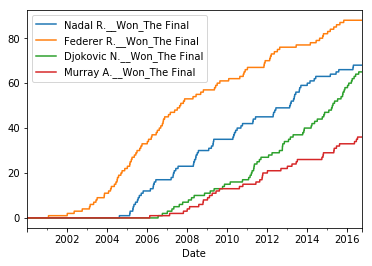

In [97]:
expanding_stats = resampled_stats.expanding().sum()
players = ["Nadal R.", "Federer R.", "Djokovic N.", "Murray A."]
expanding_stats[[p + "__Won_The Final" for p in players]].plot()

#### Looking at the "dynamic" (1Y half life exponential weighted average)

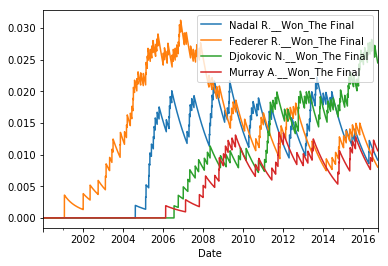

In [99]:
rolling_1Y_stats = resampled_stats.ewm(halflife=365).mean()
rolling_1Y_stats[[p + "__Won_The Final" for p in players]].plot()